## This is the solution for the assignment #8
* The assignment is to practice the usage of One Cycle Policy learning
* We also need to implement a custom resnet architecture in this assignment

In [1]:
!git clone https://github.com/TSAI-EVA8/StarterKit.git

In [1]:
import os
import sys
import torch
from pathlib import Path
#from data.dataset import CIFAR10
import torchvision
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as transforms
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import torch.nn as nn
import copy
from torch_lr_finder import LRFinder

## functions from the starterkit

In [2]:
from StarterKit.models.custom_resnet import CustomResidualModel  ##in this case md()
from StarterKit.models.resnet18 import ResNet18 as md #.. in this case md.ResNet18()
import StarterKit.utils as utility
import StarterKit.main as main
import StarterKit.trainer as trainer
import StarterKit.gradcam as gradcamUtility
import StarterKit.transforms.CutOut as cc

In [3]:
## check for the GPU
isCuda, device = utility.initialize_cuda(112)

GPU Available? True


## Configurations

In [4]:
class Args:


    # Data Loading
    # ============

    train_batch_size = 512
    val_batch_size = 512
    num_workers = 4

    # Augmentation
    # ============
    horizontal_flip_prob = 0.7
    cutout_prob = 0.8

    # Training
    # ========
    random_seed = 1
    epochs = 24
    

## Fetch the CIFAR data and apply the transforms

In [5]:
def getCIFAR10Data(transform_Train,transform_Test):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_Train)
    trainLoader = torch.utils.data.DataLoader(trainset, batch_size=Args.train_batch_size,
                                              shuffle=True, num_workers=Args.num_workers)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_Test)
    testLoader = torch.utils.data.DataLoader(testset, batch_size=Args.val_batch_size,
                                             shuffle=False, num_workers=Args.num_workers)

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return trainLoader,testLoader,classes

In [6]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),  
     transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
     transforms.RandomCrop(32,4),
     transforms.RandomHorizontalFlip(p = Args.horizontal_flip_prob),
    ])
transform_train.transforms.append(utility.CutOut(n_holes=1, length=8,p=Args.cutout_prob))

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
    ])


train_loader,test_loader,classes=getCIFAR10Data(transform_train,transform_test)

Files already downloaded and verified
Files already downloaded and verified


## Displaying Few Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

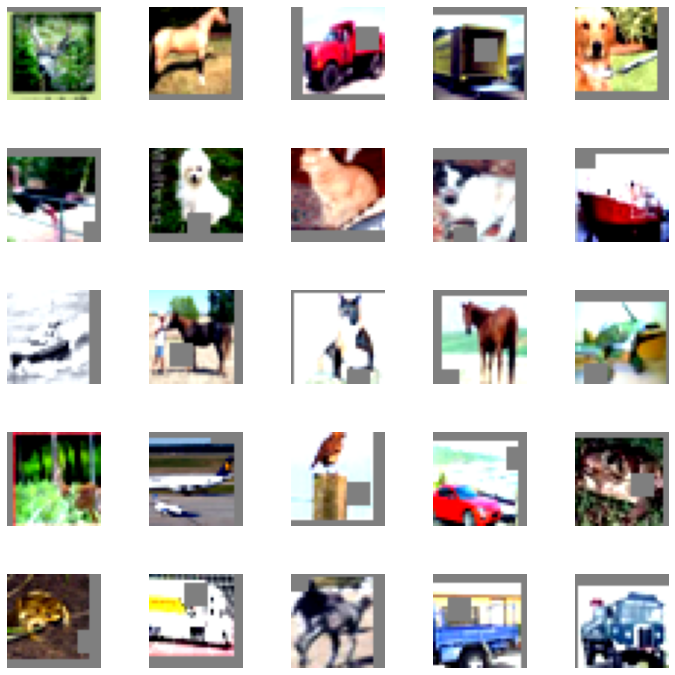

In [7]:
utility.displayImageGridFromLoader(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

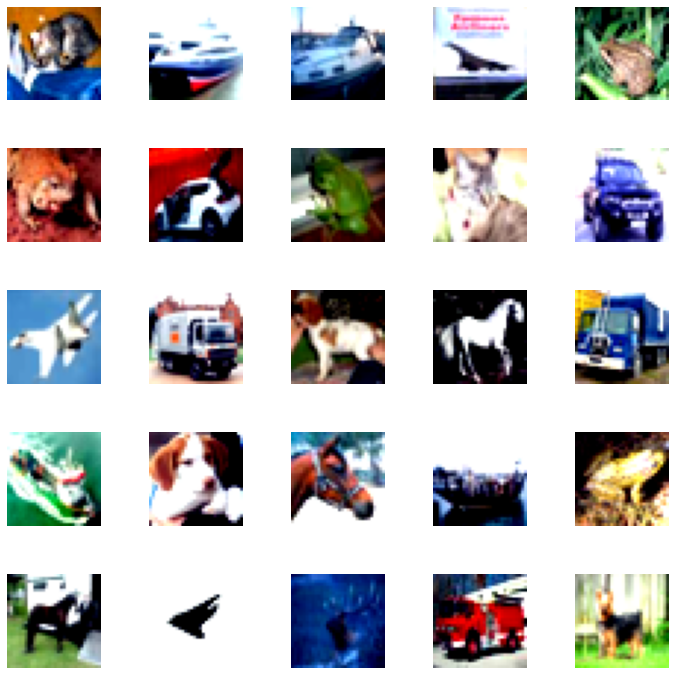

In [8]:
## the test images
utility.displayImageGridFromLoader(test_loader)

## Load the model

In [9]:
## get the model
model = CustomResidualModel().to(device)  # Create model
summary(model,input_size=(3, 32, 32))  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
customResidualBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 25

In [10]:
# def find_lr(net, optimizer, criterion, train_loader):
#     """Find learning rate for using One Cyclic LRFinder
#     Args:
#         net (instace): torch instace of defined model
#         optimizer (instance): optimizer to be used
#         criterion (instance): criterion to be used for calculating loss
#         train_loader (instance): torch dataloader instace for trainig set
#     """
#     lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
#     lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
#     lr_finder.plot()
#     min_loss = min(lr_finder.history['loss'])
#     ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
#     print("Max LR is {}".format(ler_rate))

#     lr_finder.reset()
#     return format(ler_rate)
    

## Apply the one -cycle policy. The first step is to finc the LR

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.74E-02


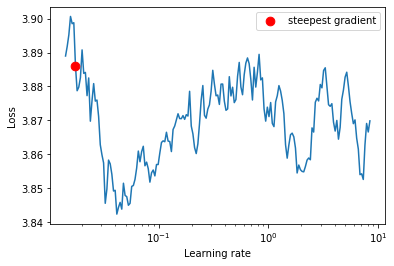

Max LR is 0.04150404757850476
The final learning rate 0.04150404757850476


In [11]:
## https://github.com/davidtvs/pytorch-lr-finder/blob/master/examples/lrfinder_cifar10.ipynb
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
## make a deep copy of the model ..this is a very important step
model_exp=copy.deepcopy(model)
ler_rate=main.find_lr(model_exp,optimizer,criterion,train_loader)

print("The final learning rate",ler_rate)

## Fitting the model with One Cycle Policy


In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=float(ler_rate),
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,## how much percent of cycle to use for building up
                                                div_factor=10,## initial learng rate max/div_factor
                                                three_phase=False, ## dont use the annihilation 
                                                final_div_factor=50,## the min rate =inital_lr/final_factor
                                                anneal_strategy='cos'## shape of the cycle
                                                )
net, history = trainer.fit_model(
    net=model, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.004150404757850473)


Batch_id=97 Loss=2.72962 Accuracy=25.86%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.32it/s]



Test set: Average loss: 1.8078, Accuracy: 3598/10000 (35.98%)

EPOCH: 2 (LR: 0.008025775067461431)


Batch_id=97 Loss=1.80117 Accuracy=41.19%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.30it/s]



Test set: Average loss: 1.8488, Accuracy: 4173/10000 (41.73%)

EPOCH: 3 (LR: 0.018043636422487283)


Batch_id=97 Loss=1.57596 Accuracy=49.68%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.29it/s]



Test set: Average loss: 1.5723, Accuracy: 5338/10000 (53.38%)

EPOCH: 4 (LR: 0.030046651596412673)


Batch_id=97 Loss=1.44390 Accuracy=56.79%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.26it/s]



Test set: Average loss: 1.1311, Accuracy: 6237/10000 (62.37%)

EPOCH: 5 (LR: 0.03905365943671732)


Batch_id=97 Loss=1.07857 Accuracy=66.71%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.25it/s]



Test set: Average loss: 0.9672, Accuracy: 6834/10000 (68.34%)

EPOCH: 6 (LR: 0.0414917986594284)


Batch_id=97 Loss=0.99910 Accuracy=69.79%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.17it/s]



Test set: Average loss: 0.8010, Accuracy: 7309/10000 (73.09%)

EPOCH: 7 (LR: 0.04109932639358546)


Batch_id=97 Loss=0.80833 Accuracy=74.79%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.15it/s]



Test set: Average loss: 0.8871, Accuracy: 7385/10000 (73.85%)

EPOCH: 8 (LR: 0.0401644185115947)


Batch_id=97 Loss=0.78183 Accuracy=76.19%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.10it/s]



Test set: Average loss: 0.8798, Accuracy: 7546/10000 (75.46%)

EPOCH: 9 (LR: 0.038712049521678074)


Batch_id=97 Loss=0.68738 Accuracy=78.96%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.09it/s]



Test set: Average loss: 0.6702, Accuracy: 7853/10000 (78.53%)

EPOCH: 10 (LR: 0.036781017044412646)


Batch_id=97 Loss=0.59902 Accuracy=81.36%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 0.6432, Accuracy: 7864/10000 (78.64%)

EPOCH: 11 (LR: 0.034422905398862724)


Batch_id=97 Loss=0.56017 Accuracy=82.30%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 0.5490, Accuracy: 8199/10000 (81.99%)

EPOCH: 12 (LR: 0.031700707613341074)


Batch_id=97 Loss=0.47316 Accuracy=84.36%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.11it/s]



Test set: Average loss: 0.5450, Accuracy: 8310/10000 (83.10%)

EPOCH: 13 (LR: 0.028687142671488683)


Batch_id=97 Loss=0.45578 Accuracy=85.56%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.08it/s]



Test set: Average loss: 0.4999, Accuracy: 8439/10000 (84.39%)

EPOCH: 14 (LR: 0.025462712945643503)


Batch_id=97 Loss=0.40646 Accuracy=86.48%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.05it/s]



Test set: Average loss: 0.4681, Accuracy: 8546/10000 (85.46%)

EPOCH: 15 (LR: 0.022113553709933044)


Batch_id=97 Loss=0.36865 Accuracy=87.85%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.03it/s]



Test set: Average loss: 0.4684, Accuracy: 8554/10000 (85.54%)

EPOCH: 16 (LR: 0.018729132179769795)


Batch_id=97 Loss=0.33257 Accuracy=88.62%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.00it/s]



Test set: Average loss: 0.5037, Accuracy: 8379/10000 (83.79%)

EPOCH: 17 (LR: 0.015399857544080117)


Batch_id=97 Loss=0.30576 Accuracy=89.74%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.01it/s]



Test set: Average loss: 0.4685, Accuracy: 8574/10000 (85.74%)

EPOCH: 18 (LR: 0.012214665834278294)


Batch_id=97 Loss=0.27432 Accuracy=90.70%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 0.5288, Accuracy: 8453/10000 (84.53%)

EPOCH: 19 (LR: 0.009258644146191949)


Batch_id=97 Loss=0.24654 Accuracy=91.41%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.01it/s]



Test set: Average loss: 0.4019, Accuracy: 8762/10000 (87.62%)

EPOCH: 20 (LR: 0.00661075767989643)


Batch_id=97 Loss=0.21662 Accuracy=92.55%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.02it/s]



Test set: Average loss: 0.3771, Accuracy: 8825/10000 (88.25%)

EPOCH: 21 (LR: 0.00434174031580624)


Batch_id=97 Loss=0.18767 Accuracy=93.62%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.01it/s]



Test set: Average loss: 0.3701, Accuracy: 8877/10000 (88.77%)

EPOCH: 22 (LR: 0.0025122050767729586)


Batch_id=97 Loss=0.17324 Accuracy=94.02%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.02it/s]



Test set: Average loss: 0.3637, Accuracy: 8896/10000 (88.96%)

EPOCH: 23 (LR: 0.001171024952050149)


Batch_id=97 Loss=0.16250 Accuracy=94.41%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 0.3592, Accuracy: 8940/10000 (89.40%)

EPOCH: 24 (LR: 0.00035402733671838633)


Batch_id=97 Loss=0.15519 Accuracy=94.77%: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.02it/s]



Test set: Average loss: 0.3601, Accuracy: 8925/10000 (89.25%)



In [14]:
# test_losses = []
# test_accuracies = []
# train_losses= []
# train_accuracies=[]
# correct_samples = []
# incorrect_samples = []

# criterion = main.cross_entropy_loss()  # Create loss function
# optimizer = main.sgd_optimizer(model, Args.learning_rate, Args.momentum)  # Create optimizer
# #scheduler = main.lr_scheduler(optimizer, Args.lr_step_size, Args.lr_gamma)
# last_epoch = False



# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
#                                                 max_lr=float(ler_rate),
#                                                 steps_per_epoch=len(train_loader), 
#                                                 epochs=Args.epochs,
#                                                 pct_start=0.2,## how much percent of cycle to use for building up
#                                                 div_factor=10,  ## initial learng rate max/div_factor
#                                                 three_phase=False, ## to stop the annihilate
#                                                 final_div_factor=50, ## the min rate =inital_lr/final_factor
#                                                 anneal_strategy='cos'
#                                                 )

# for epoch in range(1, Args.epochs+1):
#     print(f'Epoch {epoch}:')
#     if epoch == Args.epochs:
#         last_epoch = True
#     print('LR:', scheduler.get_last_lr())
#     main.train(model, train_loader, device, optimizer,train_losses,train_accuracies, criterion)
#     main.eval(
#         model, test_loader, device, criterion, test_losses, test_accuracies,
#         correct_samples, incorrect_samples, Args.sample_count, last_epoch=last_epoch
#     )
#     scheduler.step()
    

## plotting the curves


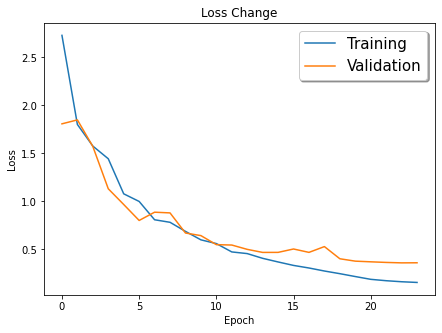

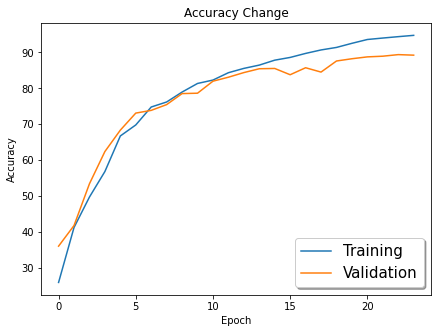

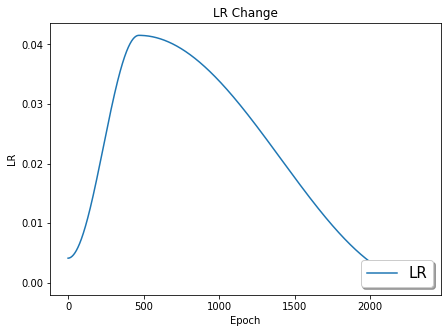

In [14]:
## get the data collected during the training of the model
train_accuracies, train_losses, test_accuracies, test_losses, lr_trend=history

utility.plot_metric({
    'Training': train_losses,
    'Validation':test_losses
}, 'Loss')

utility.plot_metric({
    'Training': train_accuracies,
    'Validation':test_accuracies
}, 'Accuracy')

utility.plot_metric({
    'LR': lr_trend
}, 'LR')


#utility.plotLossAccuracyCurve(train_losses,train_accuracies,test_losses,test_accuracies)

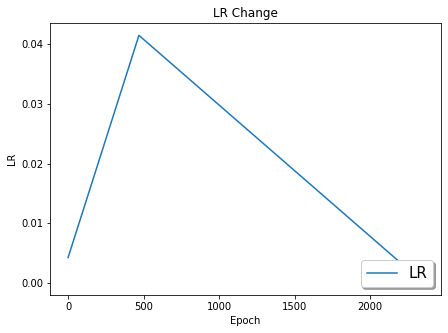

In [16]:
## in case of the anneal is linear

## print the class level accuracy summary

In [15]:
#import plottingUtils as pt
main.class_level_accuracy(model, test_loader, device, classes)

Accuracy of plane : 90 %
Accuracy of   car : 96 %
Accuracy of  bird : 84 %
Accuracy of   cat : 78 %
Accuracy of  deer : 89 %
Accuracy of   dog : 82 %
Accuracy of  frog : 92 %
Accuracy of horse : 91 %
Accuracy of  ship : 94 %
Accuracy of truck : 92 %
